In [1]:
import os, time
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from PIL import Image
from numpy import array
import numpy as np
import copy
%matplotlib inline

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 读取数据
wafer_data = pd.read_pickle("LSWMD.pkl")

In [3]:
# 提取不同类型数据
wafer_data = wafer_data.drop(['waferIndex'], axis = 1)
noType = wafer_data[wafer_data.failureType.str.len() == 0]
noneType = wafer_data[wafer_data.failureType == 'none']
wafer_data = wafer_data[wafer_data.failureType.str.len() > 0]
hasType = wafer_data[wafer_data.failureType != 'none']
hasType = hasType.reset_index(drop = True)


C:\Users\HP\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [4]:
# 重新调整图片大小
scaledimgs = []

for y in range(len(hasType)):
    img = Image.fromarray(hasType.waferMap[y])
    scimg = img.resize((32, 32), Image.ANTIALIAS)
    npscimg = np.array(scimg)
    scaledimgs.append(npscimg)

scaledimgs = np.array(scaledimgs)

In [5]:
scaledimgs.shape

(25519, 32, 32)

In [6]:
# 混合训练集和测试集的标签

scall = []
y_all = []
allcount = 0

for y in range(len(hasType)):
    scall.append(scaledimgs[y])
    allcount += 1
    y_all.append(hasType.failureType[y][:])

npall = np.array(scall)
# npy = np.array(y_all)

print("allcount: ", allcount)


allcount:  25519


In [7]:
# 标签one hot编码
from sklearn import preprocessing

fy_all = np.vstack(y_all)

one_hot = preprocessing.OneHotEncoder(sparse = False)

all_onehot = one_hot.fit_transform(fy_all)

all_onehot = np.array(all_onehot)

In [9]:
# 数字对应标签
dict_train = {}
for i in range(len(y_all[:1000])):
    dict_train[y_all[i][0][0]] =  np.argmax(all_onehot[i])

print(dict_train)

{'Loc': 4, 'Edge-Loc': 2, 'Center': 0, 'Edge-Ring': 3, 'Scratch': 7, 'Random': 6, 'Near-full': 5, 'Donut': 1}


In [10]:
# 简化图片结构：0,1 -> 1; 2 -> 1
for x in npall:
    for i in range(32):
        for j in range(32):
            if x[i][j] < 1.5:
                x[i][j] = 0
            else:
                x[i][j] = 1

In [11]:
# Test
npall[0][10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=uint8)

In [12]:
# 打乱混合标签
np.random.seed(200)
np.random.shuffle(npall)
np.random.seed(200)
np.random.shuffle(all_onehot)

In [13]:
# 整理训练数据，前20000为训练数据，其余为测试数据
x_train_tensor = torch.from_numpy(npall[:20000])
y_train_tensor = torch.from_numpy(all_onehot[:20000])
x_train_tensor = x_train_tensor.reshape([20000,1,32,32])


x_test_tensor = torch.from_numpy(npall[20000:])
y_test_tensor = torch.from_numpy(all_onehot[20000:])
x_test_tensor = x_test_tensor.reshape([-1,1,32,32])

In [14]:
# 观察训练数据，测试数据中样本分布
y_train = np.array(np.argmax(y_train_tensor,axis = 1))
y_test = np.array(np.argmax(y_test_tensor,axis = 1))

mask = np.unique(y_train)
tmp = {}
for v in mask:
    tmp[v] = np.sum(y_train == v)
print("训练集：")
print(tmp)

mask = np.unique(y_test)
tmp = {}
for v in mask:
    tmp[v] = np.sum(y_test == v)
print("测试集：")
print(tmp)

训练集：
{0: 3357, 1: 441, 2: 4059, 3: 7608, 4: 2781, 5: 108, 6: 712, 7: 934}
测试集：
{0: 937, 1: 114, 2: 1130, 3: 2072, 4: 812, 5: 41, 6: 154, 7: 259}


In [15]:
torch_dataset_train = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
torch_dataset_test = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

In [16]:
# 分类器
class classifier(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, d*2, 4, 2, 1)
        self.conv2 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*4)
        self.Linear1 = nn.Linear(d*256, 1024)
        self.Linear2 = nn.Linear(1024, 8)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
#         x = F.leaky_relu(self.conv1(input), 0.2)
#         x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
#         x = x.view(-1,64*256)
#         x = F.leaky_relu(self.Linear1(x), 0.2)
#         x = F.softmax(self.Linear2(x), dim=1)
        x = F.relu(self.conv1(input))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = x.view(-1,32*256)
        x = F.relu(self.Linear1(x))
        # x = F.softmax(self.Linear2(x), dim=1)
        x = self.Linear2(x)
  
        return x

In [17]:
# 分类器网络参数初始化
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()


In [18]:
# 训练参数
batch_size = 32
lr = 0.0002
train_epoch = 5

train_loader = torch.utils.data.DataLoader(
    torch_dataset_train,
    batch_size=batch_size, shuffle=True)

C = classifier(32)
C.weight_init(mean=0.0, std=0.02)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()
CE_loss = nn.CrossEntropyLoss()

# Adam optimizer
C_optimizer = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.999))

In [19]:
# 从测试集中抽验证集（应该从训练集中抽取）
test_x = x_test_tensor[:1000]
test_y = y_test_tensor[:1000]

In [20]:
# sortmax 结果转 onehot
def props_to_onehot(props):
    if isinstance(props, list):
        props = np.array(props)
    a = np.argmax(props, axis=1)
    b = np.zeros((len(a), props.shape[1]))
    b[np.arange(len(a)), a] = 1
    return b

In [21]:
num_iter = 0

for epoch in range(train_epoch):
    for b_x, b_y in train_loader:   # gives batch data, normalize x when iterate train_loader
        C.train()
        fb_x = b_x.float()
        output = C(fb_x)       # cnn output
        output = output.to(torch.float64)
#         print("output: ")
#         print(output)
#         print(b_y)
       # loss = BCE_loss(output, b_y)
        b_y = torch.topk(b_y, 1)[1].squeeze(1)
        loss = CE_loss(output, b_y)
#         print("loss: ")
#         print(loss)
#         break
        C_optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        C_optimizer.step()                # apply gradients
        
        num_iter += 1
        if num_iter%50 == 0:
            print(num_iter)
            print('Epoch: ', epoch)

    with torch.no_grad():
        C.eval()
#             npout = props_to_onehot(output.detach().numpy())
#             accuracy = float(np.sum((npout == b_y.data.numpy()).sum(axis=1) == 8))/ float(b_y.size(0))
#             print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
        ftest_x = test_x.float()
        test_output = C(ftest_x)
        npout = props_to_onehot(test_output.detach().numpy())
        accuracy = float(np.sum((npout == test_y.data.numpy()).sum(axis=1) == 8))/ float(test_y.size(0))
        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            
#             break

50
Epoch:  0
100
Epoch:  0
150
Epoch:  0
200
Epoch:  0
250
Epoch:  0
300
Epoch:  0
350
Epoch:  0
400
Epoch:  0
450
Epoch:  0
500
Epoch:  0
550
Epoch:  0
600
Epoch:  0
Epoch:  0 | train loss: 0.3041 | test accuracy: 0.84
650
Epoch:  1
700
Epoch:  1
750
Epoch:  1
800
Epoch:  1
850
Epoch:  1
900
Epoch:  1
950
Epoch:  1
1000
Epoch:  1
1050
Epoch:  1
1100
Epoch:  1
1150
Epoch:  1
1200
Epoch:  1
1250
Epoch:  1
Epoch:  1 | train loss: 0.2007 | test accuracy: 0.84
1300
Epoch:  2
1350
Epoch:  2
1400
Epoch:  2
1450
Epoch:  2
1500
Epoch:  2
1550
Epoch:  2
1600
Epoch:  2
1650
Epoch:  2
1700
Epoch:  2
1750
Epoch:  2
1800
Epoch:  2
1850
Epoch:  2
Epoch:  2 | train loss: 0.1181 | test accuracy: 0.85
1900
Epoch:  3
1950
Epoch:  3
2000
Epoch:  3
2050
Epoch:  3
2100
Epoch:  3
2150
Epoch:  3
2200
Epoch:  3
2250
Epoch:  3
2300
Epoch:  3
2350
Epoch:  3
2400
Epoch:  3
2450
Epoch:  3
2500
Epoch:  3
Epoch:  3 | train loss: 0.1126 | test accuracy: 0.86
2550
Epoch:  4
2600
Epoch:  4
2650
Epoch:  4
2700
Epoch:  

In [22]:
# 在整个测试集上测试准确率 
with torch.no_grad():
    C.eval()
    ftest_x = x_test_tensor.float()
    test_output = C(ftest_x)
    npout = props_to_onehot(test_output.detach().numpy())
    accuracy = float(np.sum((npout == y_test_tensor.data.numpy()).sum(axis=1) == 8))/ float(x_test_tensor.size(0))
    print('test accuracy: %.2f' % accuracy)

test accuracy: 0.88


In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [24]:
cm = confusion_matrix(np.argmax(npout, axis=1), np.argmax(y_test_tensor.data.numpy(), axis=1))

<AxesSubplot:>

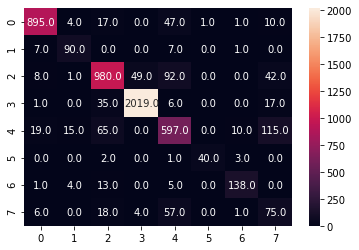

In [26]:
sns.heatmap(cm, annot=cm, fmt = '.1f',annot_kws={"size": 10})